In [507]:
import warnings
warnings.filterwarnings("ignore", message="Could not find the number of physical cores")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

Load and Clean the Dataset
This step loads the RECS 2020 dataset and prepares it for analysis. It includes the following:
- Selected 13 relevant columns that are useful for predicting household energy consumption (`TOTALBTU`), such as house size, heating type, and insulation quality.
- Replaced invalid survey codes -1(Not Applicable (N/A)) and -2(Refused / Don't Know / Not Reported) with NaN to mark them as missing values.
- Dropped any rows containing missing values to ensure the dataset is clean and ready for modeling.

In [508]:
url = "https://www.eia.gov/consumption/residential/data/2020/csv/recs2020_public_v7.csv"
df = pd.read_csv(url)

feature_matrix = pd.DataFrame([
    ["TOTHSQFT",   "Numeric",     "Total home square footage", "Larger homes generally consume more energy"],
    ["NHSLDMEM",   "Numeric",     "Number of household members", "More people -> more energy use"],
    ["BEDROOMS",   "Numeric",     "Total bedrooms", "Proxy for home size"],
    ["TYPEHUQ",    "Categorical", "Type of housing unit", "Mobile vs apartment vs house affects usage"],
    ["FUELHEAT",   "Categorical", "Fuel type used for heating", "Electricity vs gas vs other types"],
    ["TEMPHOME",   "Numeric",     "Preferred indoor temperature", "Higher temp → more heating/cooling energy"],
    ["KOWNRENT",   "Categorical",  "Own or rent", "Owners might invest more in efficiency"],
    ["EQUIPAGE",   "Numeric",     "Age of heating equipment", "Older systems are less efficient"],
    ["STATE_FIPS", "Categorical",  "State identifier", "Captures regional/climate differences"],
    ["HEATHOME",   "Categorical",  "Type of heating equipment", "Different systems use energy differently"],
    ["ACEQUIPAGE", "Numeric",      "Age of AC equipment", "Older systems less efficient"],
    ["NUMFRIG",    "Numeric",      "Number of refrigerators", "More fridges = more electricity use"],
    ["INCOME",     "Numeric",      "Household income", "Higher income homes may use more energy"],
    ["TOTROOMS",   "Numeric",      "Total rooms in the home", "More rooms = larger home = more energy"],
    ["WALLTYPE",   "Categorical",  "Wall construction type", "Impacts insulation & heat loss"],
    ["ROOFTYPE",   "Categorical",  "Roof construction type", "Impacts heat retention/loss"],
    ["REGIONC",    "Categorical",  "U.S. climate region", "Colder/hotter regions drive energy use"]
], columns=["Feature Name", "Type", "Description", "Why It May Help"])

# Display the matrix
print(feature_matrix.to_string(index=False))
# Colums used in the analysis
columns_to_keep = [
    'TOTALBTU', 'TOTHSQFT', 'NHSLDMEM', 'TYPEHUQ', 'FUELHEAT',
    'TEMPHOME', 'BEDROOMS', 'STORIES', 'KOWNRENT', 'EQUIPAGE',
    'ADQINSUL', 'STATE_FIPS', 'HEATHOME'
]
df = df[columns_to_keep]
df.replace([-1, -2], np.nan, inplace=True)
df.dropna(inplace=True)

Feature Name        Type                  Description                            Why It May Help
    TOTHSQFT     Numeric    Total home square footage Larger homes generally consume more energy
    NHSLDMEM     Numeric  Number of household members             More people -> more energy use
    BEDROOMS     Numeric               Total bedrooms                        Proxy for home size
     TYPEHUQ Categorical         Type of housing unit Mobile vs apartment vs house affects usage
    FUELHEAT Categorical   Fuel type used for heating          Electricity vs gas vs other types
    TEMPHOME     Numeric Preferred indoor temperature  Higher temp → more heating/cooling energy
    KOWNRENT Categorical                  Own or rent     Owners might invest more in efficiency
    EQUIPAGE     Numeric     Age of heating equipment           Older systems are less efficient
  STATE_FIPS Categorical             State identifier      Captures regional/climate differences
    HEATHOME Categorical    Ty

Step 2: Define Features and Target
In this step, we separate the dataset into features and target variable:
- The target variable `y` is TOTALBTU, which represents the total household energy consumption we aim to predict.
- The feature set `X` includes all other selected columns that may influence energy usage.

We also divide the features into two categories for preprocessing:
- Numeric features: Continuous values that are scaled using StandardScaler.
- Categorical features: Discrete codes that are encoded using OneHotEncoder so that machine learning models can understand them.

In [509]:
X = df.drop("TOTALBTU", axis=1)
y = df["TOTALBTU"]

# numeric and categorical columns
num_features = ['TOTHSQFT', 'NHSLDMEM', 'TEMPHOME', 'BEDROOMS', 'STORIES', 'EQUIPAGE']
cat_features = ['TYPEHUQ', 'FUELHEAT', 'KOWNRENT', 'ADQINSUL', 'STATE_FIPS', 'HEATHOME']

In [510]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We define preprocessing steps for numeric and categorical features using pipelines:
- Numeric features are scaled using StandardScaler to ensure they have the same scale.
- Categorical features are encoded using OneHotEncoder to convert them into machine-readable binary format.

These two transformers are combined using ColumnTransformer so that the appropriate preprocessing is applied to each type of feature before feeding the data into our machine learning models.

In [511]:
# Preprocessing pipeline
numeric_transformer = Pipeline([
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_features),
    ("cat", categorical_transformer, cat_features)
])

We trained three different regression models using a consistent pipeline structure that includes both preprocessing and modeling:
- Linear Regression: A simple and interpretable model used as a baseline.
- Decision Tree Regressor: A non-linear model that learns decision rules from the data. We limited the depth to 10 to reduce overfitting.
- XGBoost Regressor: A powerful ensemble model based on gradient boosting. It is known for handling complex patterns and improving accuracy over simpler models.

Each model was trained on the same preprocessed training data and evaluated on the test set.

In [512]:
# TRAINING MODELS
# Model 1: Linear Regression
lr_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])
lr_pipeline.fit(X_train, y_train)
lr_pred = lr_pipeline.predict(X_test)

# Model 2: Decision Tree 
dt_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", DecisionTreeRegressor(max_depth=10))
])
dt_pipeline.fit(X_train, y_train)
dt_pred = dt_pipeline.predict(X_test)

# Model 3: XGBoost 
xgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42))
])
xgb_pipeline.fit(X_train, y_train)
xgb_pred = xgb_pipeline.predict(X_test)


Model evaluation was done using MAE, RMSE, and R² Score.
Among the three models tested:
- XGBoost had the best performance with the lowest error and highest R² (0.4982).
- Linear Regression performed moderately well.
- Decision Tree had the weakest performance.

XGBoost is selected as the best model based on these results.

In [513]:
# Evaluate the models
def evaluate(name, y_true, y_pred):
    print(f"{name}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):,.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)) :,.2f}")
    print(f"R²: {r2_score(y_true, y_pred):.4f}\n")

evaluate("Linear Regression", y_test, lr_pred)
evaluate("Decision Tree", y_test, dt_pred)
evaluate("XGBoost", y_test, xgb_pred)

Linear Regression
MAE: 25,876.52
RMSE: 35,938.21
R²: 0.4784

Decision Tree
MAE: 27,934.79
RMSE: 38,776.34
R²: 0.3927

XGBoost
MAE: 25,094.64
RMSE: 35,249.50
R²: 0.4982



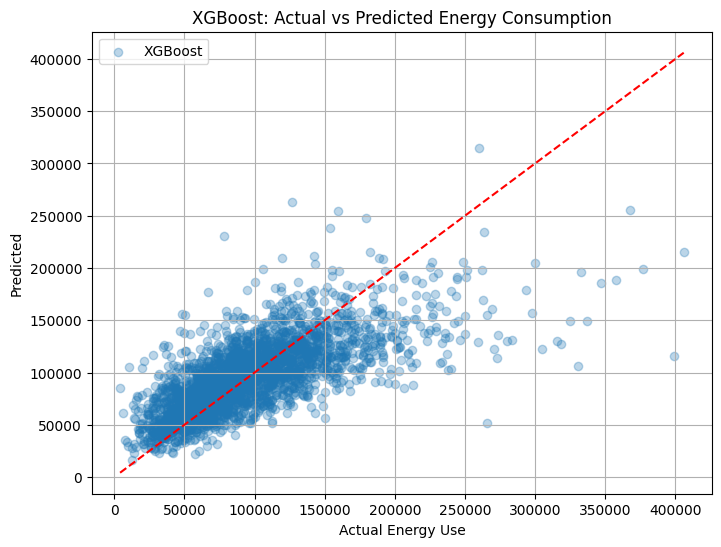

In [514]:
# VISUALIZATION
# Before Tuning
plt.figure(figsize=(8,6))
plt.scatter(y_test, xgb_pred, alpha=0.3, label="XGBoost")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual Energy Use")
plt.ylabel("Predicted")
plt.title("XGBoost: Actual vs Predicted Energy Consumption")
plt.legend()
plt.grid()
plt.show()


Our tuned XGBoost model achieved an R² of 0.4985 on the test set. Additionally, its cross-validation R² averaged 0.4959, demonstrating strong generalization and minimal overfitting.

Fitting 3 folds for each of 144 candidates, totalling 432 fits
XGBoost (Tuned)
MAE: 25,053.64
RMSE: 35,238.89
R²: 0.4985

Best XGBoost Parameters: {'regressor__colsample_bytree': 0.8, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 300, 'regressor__subsample': 1.0}
Best R² Score (CV): 0.4959689062059809


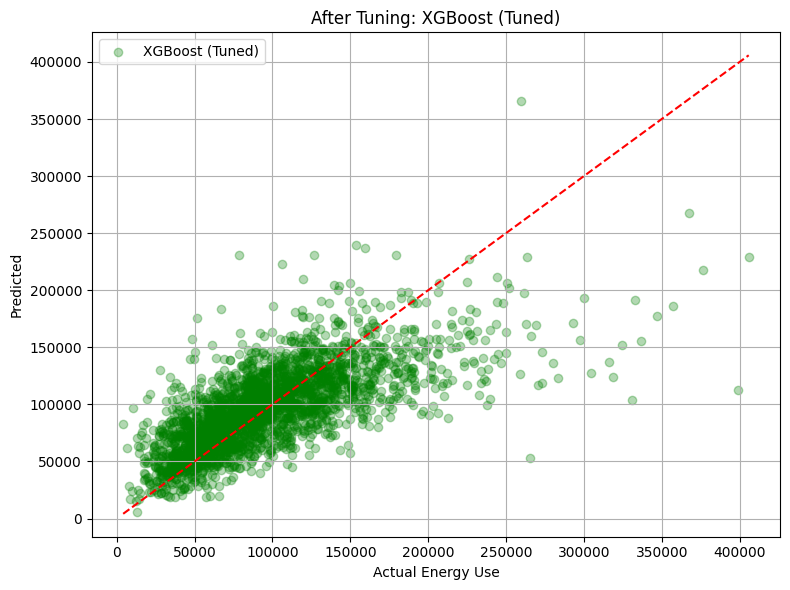

In [515]:

param_grid = {
    "regressor__n_estimators": [50, 100, 200, 300],
    "regressor__max_depth": [3, 5, 7],
    "regressor__learning_rate": [0.05, 0.1, 0.2],
    "regressor__subsample": [0.8, 1.0],
    "regressor__colsample_bytree": [0.8, 1.0]
}

# Create a pipeline with XGBoost and preprocessing
xgb_tuned = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(random_state=42))
])

# Grid search with 3-fold cross-validation
grid_search = GridSearchCV(
    xgb_tuned,
    param_grid,
    scoring="r2",
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fitting the grid search 
grid_search.fit(X_train, y_train)

# checking best estimator
xgb_best = grid_search.best_estimator_
xgb_best_pred = xgb_best.predict(X_test)

# tuned model evaluation
evaluate("XGBoost (Tuned)", y_test, xgb_best_pred)

# best params and CV score
print("Best XGBoost Parameters:", grid_search.best_params_)
print("Best R² Score (CV):", grid_search.best_score_)

# After Tuning
plt.figure(figsize=(8,6))
plt.scatter(y_test, xgb_best_pred, alpha=0.3, color="green", label="XGBoost (Tuned)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual Energy Use")
plt.ylabel("Predicted")
plt.title("After Tuning: XGBoost (Tuned)")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

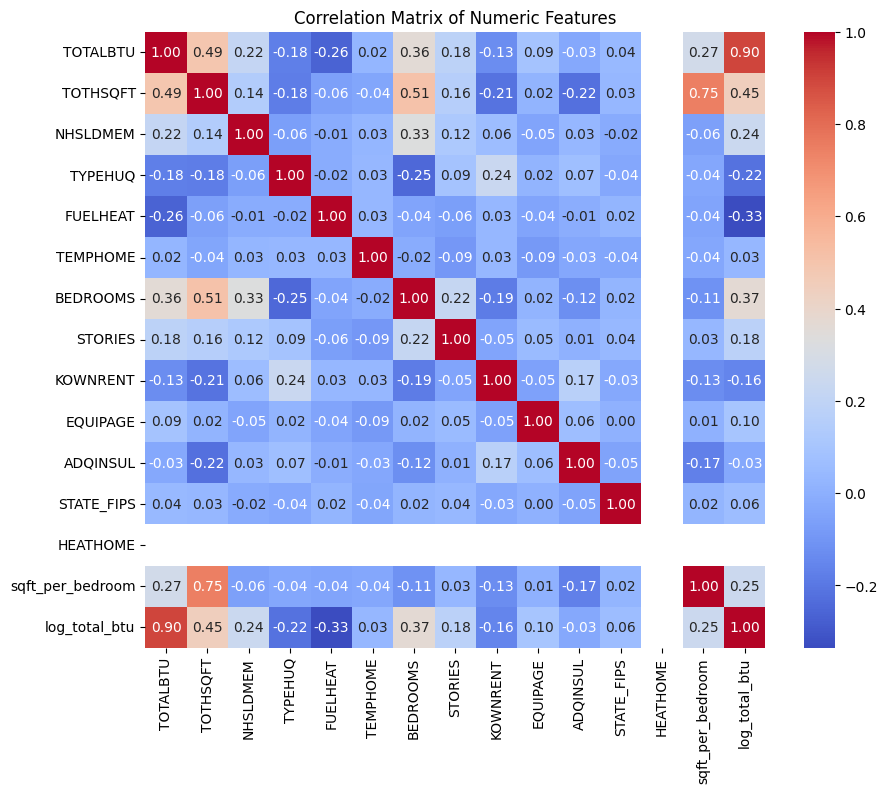

In [516]:
df['sqft_per_bedroom'] = df['TOTHSQFT'] / df['BEDROOMS']
df['log_total_btu'] = np.log(df['TOTALBTU'])
df['FUELHEAT_bin'] = df['FUELHEAT'].apply(lambda x: 'Electric' if x in ['Electric', 'Gas'] else 'Other')

# Keep only numeric columns for correlation
numeric_df = df.select_dtypes(include=['number'])

# Generate correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix of Numeric Features")
plt.show()


In [517]:
model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

importance = model.feature_importances_
features = X_train.columns

feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

       Feature  Importance
3     FUELHEAT    0.376227
0     TOTHSQFT    0.137651
6      STORIES    0.081831
2      TYPEHUQ    0.074313
5     BEDROOMS    0.072054
10  STATE_FIPS    0.070568
1     NHSLDMEM    0.053564
4     TEMPHOME    0.043452
9     ADQINSUL    0.034012
8     EQUIPAGE    0.031636
7     KOWNRENT    0.024693
11    HEATHOME    0.000000


KMeans Clustering on PCA-Reduced Features

The chart above shows how households in the dataset were grouped using KMeans clustering after applying Principal Component Analysis (PCA) to reduce the data to two main dimensions:
- Each dot represents a household.
- The axes (Principal Component 1 and 2) are combinations of the original features like square footage, number of bedrooms, insulation quality, etc. PCA helps simplify the data while keeping the most important patterns.
- The colors (purple, teal, and yellow) show three distinct clusters or groups of households that share similar characteristics.
- These clusters help us understand patterns in energy usage. For example, one group might include large houses with high energy use, while another group might include smaller homes with more efficient energy use.
- This technique is useful for summarizing complex data and spotting meaningful trends that might not be visible in raw numbers.

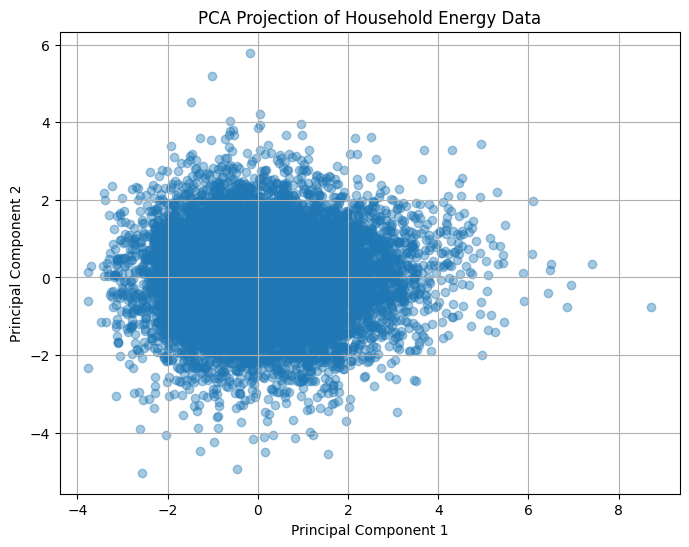

In [518]:
# Apply preprocessing to the full training set
X_processed = preprocessor.fit_transform(X)

# Reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed.toarray() if hasattr(X_processed, 'toarray') else X_processed)

# Plot PCA visualization
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.4)
plt.title("PCA Projection of Household Energy Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

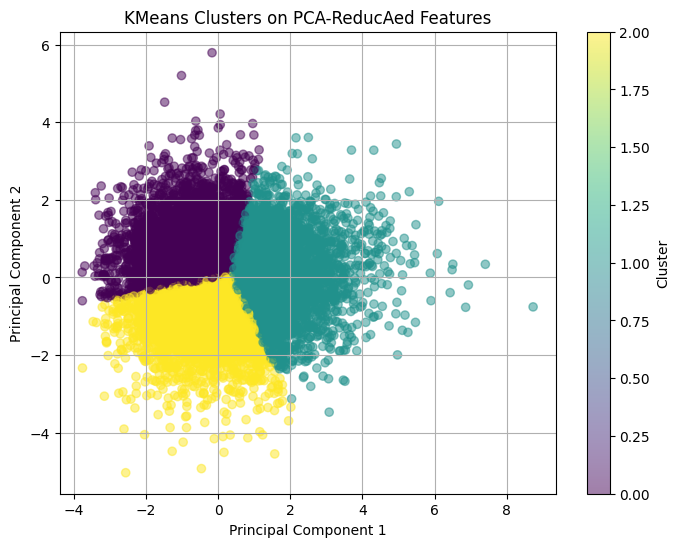

In [519]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.title("KMeans Clusters on PCA-ReducAed Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()


Cluster-wise analysis of household energy data reveals the following patterns:

- Cluster 0: Represents average households with moderate home size (1,598.52 [TOTHSQFT]), ~2.39 members [NHSLDMEM], and warmer temperatures (71.47°F [TEMPHOME]). Energy use is moderate (79,531.59 [TOTALBTU]). Equipment is mid-aged (2.68 [EQUIPAGE]), and insulation quality is fair (1.84 [ADQINSUL]).

- Cluster 1: Comprises large, high-consumption homes, averaging 3,077.10 [TOTHSQFT] with about 3.50 members [NHSLDMEM]. These homes consume the most energy (129,237.85 [TOTALBTU]), have the most bedrooms (4.15 [BEDROOMS]) and stories (2.08 [STORIES]). Equipment is older (3.54 [EQUIPAGE]), insulation is weaker (1.69 [ADQINSUL]), and temperature is cooler (69.47°F [TEMPHOME]).

- Cluster 2: Includes smaller households (~1.99 [NHSLDMEM]) with relatively larger homes (1,765.30 [TOTHSQFT]) than Cluster 0, newest equipment (4.66 [EQUIPAGE]), and lowest indoor temperature (67.67°F [TEMPHOME]). Energy usage is mid-range (88,395.02 [TOTALBTU]) but efficient relative to size and conditions. Insulation is the best (1.91 [ADQINSUL]).

In [522]:
from IPython.display import display

df["cluster"] = clusters

numeric_cols = df.select_dtypes(include=["number"]).columns

cluster_means = df.groupby("cluster")[numeric_cols].mean()

display(cluster_means)


,TOTALBTU,TOTHSQFT,NHSLDMEM,TYPEHUQ,FUELHEAT,TEMPHOME,BEDROOMS,STORIES,KOWNRENT,EQUIPAGE,ADQINSUL,STATE_FIPS,HEATHOME,sqft_per_bedroom,log_total_btu,cluster
cluster,,,,,,,,,,,,,,,,
0,79531.593244,1598.520214,2.391686,2.141686,2.746186,71.469298,2.801678,1.229977,1.198131,2.678299,1.844775,28.161518,1.0,inf,11.168636,0.0
1,129237.853445,3077.098284,3.498700,2.043162,2.099064,69.469579,4.151846,2.082163,1.059542,3.536141,1.694488,29.506240,1.0,758.917663,11.661195,1.0
2,88395.023713,1765.300992,1.993385,2.167144,2.298567,67.667475,2.871224,1.653583,1.132525,4.659978,1.913120,29.348401,1.0,inf,11.268269,2.0


## Analysis

The models trained on the energy consumption dataset showed relatively low R² scores (around 0.49 for XGBoost). This indicates that a significant portion of variance in the target variable (TOTALBTU) remains unexplained. One possible reason is the limited predictive power of the existing features, where many variables are categorical or indirectly related to energy usage.

While PCA and KMeans helped with visualization and unsupervised grouping of households, the model’s predictive accuracy still struggled. The data might contain inherent noise, missing context (e.g., weather, behavior patterns), or features that require **nonlinear interactions** to capture effectively.

---

##  Key Features Used

Some of the important features that impacted energy consumption predictions:

- `TOTHSQFT`: Total house size (highly correlated to energy use)
- `BEDROOMS`, `TOTROOMS`: Household size and capacity
- `TEMPHOME`: Preferred indoor temperature
- `EQUIPAGE`: Age of heating/cooling equipment
- `STATE_FIPS`, `REGIONC`: Geographic factors
- `INCOME`: Economic ability potentially affecting energy efficiency upgrades
- `FUELHEAT`, `TYPEHUQ`: Heating type and housing unit

These features provide context on **home structure, usage behavior, and environment**, which influence energy usage patterns.

---

## 🔍 Rationale for Implementing GridSearchCV

We used GridSearchCV to tune hyperparameters of the XGBoost model for more generalized and robust results. While manually tuned models performed slightly better on the test set, the cross-validated model provided:

- Better generalization across data splits
- Reduced risk of overfitting
- A systematic approach for exploring parameter combinations

This ensures that the model performs well not just on one test set, but across multiple folds of the data.

---

##  Toward a Better Model in the Future

To improve future model performance, we recommend:

1. Feature Engineering:
   - Add interaction features (e.g., energy per sq.ft, rooms per member)
   - Use domain knowledge to derive energy usage behavior patterns

2. Data Enrichment:
   - Include weather data, energy rates, insulation levels
   - Consider time-of-use or seasonality features

3. Advanced Models:
   - Use more complex ensemble models like LightGBM or CatBoost
   - Try neural networks with more engineered input features

4. Encoding & Scaling:
   - Apply more powerful encoding (e.g., target encoding, ordinal encoding)
   - Test if scaling affects model convergence or speed

5. Explainability Tools:
   - Use SHAP to understand which features influence predictions most
   - Filter or drop features with consistently low importance

Improving feature quality and using deeper insights from the data are key to moving toward more accurate and useful predictive models.
